In [1]:
%matplotlib inline

In [2]:
%run ~/src/starry/notebooks/notebook_setup.py

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta as Beta
from scipy.special import beta as EulerBeta
from scipy.special import legendre
from scipy.integrate import quad, IntegrationWarning
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from tqdm import tqdm
import warnings
import logging
import os

logger = logging.getLogger("starry_process.transforms")
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO)

PATH = "."

In [4]:
def rhop_to_hwhm(rhop):
    """
    Return the theoretical half-witdth at half minimum as a function of rho'.
    
    """
    return (
        np.arccos((2 + 3 * rhop * (2 + rhop)) / (2 * (1 + rhop) ** 3))
        * 180
        / np.pi
    )


def hwhm_to_rhop(hwhm):
    """
    Return rho' as a function of the theoretical half-width at half minimum.
    
    """
    theta = hwhm * np.pi / 180
    return (1 + np.cos(2 * theta / 3) + np.sqrt(3) * np.sin(2 * theta / 3)) / (
        2 * np.cos(theta)
    ) - 1


def rhop_max(hwhm_max):
    """
    Returns the value of rho' corresponding to `hwhm_max`.
    
    """
    f = lambda rhop: (rhop_to_hwhm(rhop) - hwhm_max) ** 2
    res = minimize(f, 2.0)
    return res.x[0]


def corr(rhop, c):
    """Intensity correction function."""
    rho = (rhop - c[0]) / c[1]
    return 1 + c[2] * (1 - rho) ** c[3]


def I(ydeg, rhop, theta, c=None):
    """
    Return the intensity at polar angle `theta` (in deg) away from
    the center of a spot of radius rho' expanded to degree `ydeg`.
    
    """
    # Compute the Legendre expansion
    cost = np.cos(theta * np.pi / 180)
    term = np.sum(
        [(1 + rhop) ** -l * legendre(l)(cost) for l in range(ydeg + 1)], axis=0
    )
    I = 0.5 * rhop * (1 - (2 + rhop) / (1 + rhop) * term)

    # Apply the intensity correction
    if c is not None:
        I *= corr(rhop, c)

    return I


def rhop_to_hwhm_empirical(ydeg, rhop):
    """
    Return the empirical half-width at half minimum as a function of rho'.
    
    """
    # Setup
    rhop = np.atleast_1d(rhop)
    hwhm_empirical = np.zeros_like(rhop)

    # Find the HWHM numerically for each radius
    for k in range(len(rhop)):

        halfmax = 0.5 * I(ydeg, rhop[k], 0)

        def loss(theta):
            return (I(ydeg, rhop[k], theta) - halfmax) ** 2

        res = minimize(loss, rhop_to_hwhm(max(0.1, rhop[k])))
        hwhm_empirical[k] = res.x[0]

    return hwhm_empirical


def get_c(ydeg, hwhm_max=75, hwhm_min=15, c_npts=500, **kwargs):
    """
    Return the coefficients for the radius transformation.

    """
    logger.info(
        "Computing radius transform coefficients..."
    )
    c = np.zeros(4)

    # Minimum rho': we need to optimize numerically
    loss = lambda p: (rhop_to_hwhm_empirical(ydeg, p[0]) - hwhm_min) ** 2
    res = minimize(loss, hwhm_to_rhop(hwhm_min))
    rhopmin = res.x[0]
    c[0] = rhopmin

    # Maximum rho' (easy)
    rhopmax = rhop_max(hwhm_max)
    c[1] = rhopmax - rhopmin

    # Now compute the coefficients of the intensity
    # correction, c[2] and c[3].

    # Array over which to compute the loss
    rhop = np.linspace(rhopmin + 1e-6, rhopmax - 1e-6, c_npts)

    # Get the actual (absolute value of the) intensity at the peak
    l = np.arange(ydeg + 1).reshape(1, -1)
    term = np.sum((1 + rhop.reshape(-1, 1)) ** -l, axis=-1)
    I = -0.5 * rhop * (1 - (2 + rhop) / (1 + rhop) * term)

    # This is the factor by which we need to normalize the function
    norm = 1.0 / I

    # Find the coefficients of the fit (least squares)
    diff = lambda p: np.sum((norm - corr(rhop, [c[0], c[1], p[0], p[1]])) ** 2)
    res = minimize(diff, [0.1, 50.0])
    c[2:] = res.x

    # Log the deets
    logger.info(
        "Delta theta range: {:.2f} - {:.2f} degrees".format(hwhm_min, hwhm_max)
    )
    logger.info("c coeffs: {:s}".format(" ".join(["{:.8f}".format(ck) for ck in c])))
    logger.info(
        "Maximum intensity |error|: {:.2e}".format(
            np.max(np.abs(norm - corr(rhop, c)))
        )
    )
    logger.info(
        "Average intensity |error|: {:.2e}".format(
            np.mean(np.abs(norm - corr(rhop, c)))
        )
    )

    return c

In [5]:
def get_moment(alpha, beta, n, c):
    """
    Compute the `nth` moment of the distribution of `hwhm` given `alpha` and `beta`.
    
    """
    # We'll catch integration warnings
    warnings.filterwarnings("error", category=IntegrationWarning)
    
    # Normalization factor
    fac = 1.0 / EulerBeta(alpha, beta)

    def f(x):
        return (
            fac
            * rhop_to_hwhm(c[0] + c[1] * x) ** n
            * x ** (alpha - 1)
            * (1 - x) ** (beta - 1)
        )

    def f_reparam(y, alpha, beta, reverse=False, min_ln=-100):
        if y < min_ln:
            beta_term = 1 - (beta - 1) * np.exp(y)
        else:
            beta_term = (1 - np.exp(y)) ** (beta - 1)
        if reverse:
            rho = 1 - np.exp(y)
        else:
            rho = np.exp(y)
        return (
            fac * rhop_to_hwhm(c[0] + c[1] * rho) ** n * np.exp(y * alpha) * beta_term
        )

    try:
        # Attempt to take the integral directly
        res, err = quad(f, 0, 1)

    except IntegrationWarning:
        # The Beta distribution can be tricky to integrate
        # when one or both of the parameters are really small,
        # since the dynamic range of the pdf is huge.
        # We can get better performance by splitting the integral
        # into two parts and substituting y = ln(x) in the left
        # half and y = ln(1 - x) in the right half.
        res1, err1 = quad(f_reparam, -np.inf, np.log(0.5), args=(alpha, beta, False))
        res2, err2 = quad(f_reparam, -np.inf, np.log(0.5), args=(beta, alpha, True))
        res = res1 + res2
        err = err1 + err2

    # Reset the filter
    warnings.resetwarnings()
            
    return res


def get_hwhm_mean_std(alpha, beta, c):
    """
    Return the mean and std. dev of the `hwhm` distribution given `alpha` and `beta`.
    
    """
    mean = get_moment(alpha, beta, 1, c)
    std = np.sqrt(get_moment(alpha, beta, 2, c) - mean ** 2)
    return mean, std


def get_A(x1, x2, poly_order):
    """
    Return a bivariate Vandermonde design matrix.
    
    """
    A = np.ones_like(x1).reshape(-1, 1)
    for n in range(1, poly_order + 1):
        for k in range(n + 1):
            A = np.hstack((A, (x1 ** (n - k) * x2 ** k).reshape(-1, 1)))
    return A


def get_hwhm_coeffs(c, **kwargs):

    logger.info("Computing radius pdf transform...")

    # Fine-tuning params
    mom_grid_res = kwargs.get("mom_grid_res", 100)
    max_std = kwargs.get("max_std", 30.0)
    ln_alpha_min = kwargs.get("ln_alpha_min", -5.0)
    ln_alpha_max = kwargs.get("ln_alpha_max", 5.0)
    ln_beta_min = kwargs.get("ln_beta_min", -5.0)
    ln_beta_max = kwargs.get("ln_beta_max", 5.0)
    std_lim_tol = kwargs.get("std_lim_tol", 0.75)
    poly_order = kwargs.get("poly_order", 10)

    # Grid of Beta params
    lnalpha = np.linspace(ln_alpha_min, ln_alpha_max, mom_grid_res)
    lnbeta = np.linspace(ln_beta_min, ln_beta_max, mom_grid_res)
    lnalpha, lnbeta = np.meshgrid(lnalpha, lnbeta)
    lnalpha = lnalpha.reshape(-1)
    lnbeta = lnbeta.reshape(-1)
    alpha = np.exp(lnalpha)
    beta = np.exp(lnbeta)
    beta_mean = alpha / (alpha + beta)
    beta_std = np.sqrt(alpha * beta / ((alpha + beta) ** 2 * (alpha + beta + 1)))

    # Compute the mean and std dev of hwhm
    hwhm_mean = np.empty_like(alpha)
    hwhm_std = np.empty_like(alpha)
    for k in tqdm(range(len(alpha))):
        hwhm_mean[k], hwhm_std[k] = get_hwhm_mean_std(alpha[k], beta[k], c)

    # Global max and min values for each
    hwhm_mean_lims = (np.min(hwhm_mean), np.max(hwhm_mean))
    hwhm_std_lims = (np.min(hwhm_std), np.max(hwhm_std))

    # The limits of hwhwm std. dev. depend on the hwhm mean.
    # Get the minimum (y1) and maximum (y2) hwhwm_std at each value of hwhm_mean
    x = np.linspace(hwhm_mean_lims[0], hwhm_mean_lims[1], mom_grid_res // 3)
    y1 = np.zeros_like(x) * np.nan
    y2 = np.zeros_like(x) * np.nan
    dx = x[1] - x[0]
    for k in range(len(x)):
        vals = hwhm_std[np.abs(hwhm_mean - x[k]) < 0.5 * dx]
        if len(vals):
            y2[k] = np.max(vals[vals < max_std])
            y1[k] = np.min(vals)

    # Add a little padding
    a, b = hwhm_mean_lims
    xp = (x + std_lim_tol) * (b - a) / (b - a + 2 * std_lim_tol)
    y1p = y1 + std_lim_tol
    y2p = y2 - std_lim_tol

    # Get the interpolant
    y1 = interp1d(xp, y1p, kind="cubic", fill_value="extrapolate")
    y2 = interp1d(xp, y2p, kind="cubic", fill_value="extrapolate")

    # Fit a bivariate polynomial to the grid data
    x1 = (hwhm_mean - hwhm_mean_lims[0]) / (hwhm_mean_lims[1] - hwhm_mean_lims[0])
    x2 = (hwhm_std - hwhm_std_lims[0]) / (hwhm_std_lims[1] - hwhm_std_lims[0])
    A = get_A(x1, x2, poly_order)
    hwhm_mean_coeffs = np.linalg.solve(A.T @ A, A.T @ beta_mean)
    hwhm_std_coeffs = np.linalg.solve(A.T @ A, A.T @ beta_std)

    return (
        hwhm_mean_coeffs,
        hwhm_mean_lims[0],
        hwhm_mean_lims[1],
        hwhm_std_coeffs,
        hwhm_std_lims[0],
        hwhm_std_lims[1],
        y1,
        y2,
    )

In [98]:
class SizeTransform(object):
    """
    Class hosting variable transforms for the spot size distribution.
    
    """

    def __init__(self, ydeg=15, hwhm_min=15, hwhm_max=75, clobber=False, **kwargs):
        # Store the main ones
        self._ydeg = ydeg
        self._hwhm_min = hwhm_min
        self._hwhm_max = hwhm_max
        self._poly_order = kwargs.get("poly_order", 10)
        self._mom_grid_res = kwargs.get("mom_grid_res", 100)

        # Get the kwargs hash
        kwargs.update(dict(ydeg=ydeg, hwhm_min=hwhm_min, hwhm_max=hwhm_max))
        self._hash = self._get_hash(**kwargs)

        # Attempt to load cached params from disk
        if clobber or not self._load():

            # Get the radius transform coeffs
            self.c = get_c(**kwargs)

            # Get the Beta distribution transform coeffs
            (
                self._mean_coeffs,
                self._mean_min,
                self._mean_max,
                self._std_coeffs,
                self._std_min,
                self._std_max,
                self._std_min_func,
                self._std_max_func,
            ) = get_hwhm_coeffs(self.c, **kwargs)

            # Save!
            self._save()

    def _save(self):
        """
        Save the contents of this class to disk.
        
        """
        x = np.concatenate(
            (
                self.c,
                self._mean_coeffs,
                np.atleast_1d(self._mean_min),
                np.atleast_1d(self._mean_max),
                self._std_coeffs,
                np.atleast_1d(self._std_min),
                np.atleast_1d(self._std_max),
                self._std_min_func.x,
                self._std_min_func.y,
                self._std_max_func.x,
                self._std_max_func.y,
            )
        )
        np.savetxt(os.path.join(PATH, self._hash), x)

    def _load(self):
        """
        Load the contents of this class from disk.
        
        """
        if os.path.exists(os.path.join(PATH, self._hash)):
            x = np.loadtxt(os.path.join(PATH, self._hash))
            ncoeffs = 0
            for i in range(self._poly_order + 1):
                for j in range(i + 1):
                    ncoeffs += 1
            self.c, x = np.split(x, [4])
            self._mean_coeffs, x = np.split(x, [ncoeffs])
            self._mean_min, x = np.split(x, [1])
            self._mean_min = self._mean_min[0]
            self._mean_max, x = np.split(x, [1])
            self._mean_max = self._mean_max[0]
            self._std_coeffs, x = np.split(x, [ncoeffs])
            self._std_min, x = np.split(x, [1])
            self._std_min = self._std_min[0]
            self._std_max, x = np.split(x, [1])
            self._std_max = self._std_max[0]
            _x, x = np.split(x, [self._mom_grid_res // 3])
            _y, x = np.split(x, [self._mom_grid_res // 3])
            self._std_min_func = interp1d(
                _x, _y, kind="cubic", fill_value="extrapolate"
            )
            _x, x = np.split(x, [self._mom_grid_res // 3])
            _y, x = np.split(x, [self._mom_grid_res // 3])
            self._std_max_func = interp1d(
                _x, _y, kind="cubic", fill_value="extrapolate"
            )
            return True
        else:
            return False

    def _get_hash(self, **kwargs):
        """
        Return a hash string representation of the input kwargs.
        
        """
        ydeg = kwargs.get("ydeg", 15)
        hwhm_min = kwargs.get("hwhm_min", 15)
        hwhm_max = kwargs.get("hwhm_max", 75)
        mom_grid_res = kwargs.get("mom_grid_res", 100)
        max_std = kwargs.get("max_std", 30.0)
        ln_alpha_min = kwargs.get("ln_alpha_min", -5.0)
        ln_alpha_max = kwargs.get("ln_alpha_max", 5.0)
        ln_beta_min = kwargs.get("ln_beta_min", -5.0)
        ln_beta_max = kwargs.get("ln_beta_max", 5.0)
        std_lim_tol = kwargs.get("std_lim_tol", 0.75)
        poly_order = kwargs.get("poly_order", 10)
        params = [
            ydeg,
            hwhm_min,
            hwhm_max,
            mom_grid_res,
            max_std,
            ln_alpha_min,
            ln_alpha_max,
            ln_beta_min,
            ln_beta_max,
            std_lim_tol,
            poly_order,
        ]
        return hex(int("".join(["{:.0f}".format(abs(param) * 10) for param in params])))

    def get_alpha_beta(self, mean, std):
        """
        Return the `alpha` and `beta` parameters of the Beta distribution
        corresponding to a given HWHM `mean` and `std`.
        
        """
        # Bounds checks
        mean = np.array(mean)
        std = np.array(std)
        assert np.all(
            (mean > self._mean_min) & (mean < self._mean_max)
        ), "mean is out of bounds"
        assert np.all(
            (std > self._std_min) & (std < self._std_max)
        ), "std is out of bounds"

        assert np.all(
            (std > self._std_min_func(mean)) & (std < self._std_max_func(mean))
        ), "std is out of bounds"

        # Linear fit
        x1 = (mean.reshape(-1) - self._mean_min) / (self._mean_max - self._mean_min)
        x2 = (std.reshape(-1) - self._std_min) / (self._std_max - self._std_min)
        A = get_A(x1, x2, self._poly_order)

        # Beta mean and variance
        beta_mean = (A @ self._mean_coeffs).reshape(mean.shape)
        beta_var = ((A @ self._std_coeffs).reshape(std.shape)) ** 2

        # Convert to standard params
        alpha = (beta_mean / beta_var) * ((1 - beta_mean) * beta_mean - beta_var)
        beta = beta_mean + (beta_mean / beta_var) * (1 - beta_mean) ** 2 - 1
        return alpha, beta

    def get_rho_prime(self, rho):
        """
        Return the transformed radius parameter, rho'.
        
        """
        return self.c[0] + self.c[1] * rho

    def get_s(self, rho):
        """
        Return the spot spherical harmonic expansion vector `s(rho)`.

        """
        rho = np.atleast_1d(rho)
        assert len(rho.shape) == 1
        K = rho.shape[0]
        rho_prime = self.get_rho_prime(rho)
        sm0 = np.zeros((K, self._ydeg + 1))
        sm0[:, 0] = 0.5 * rho_prime
        for l in range(self._ydeg + 1):
            sm0[:, l] -= (
                rho_prime
                * (2 + rho_prime)
                / (2 * np.sqrt(2 * l + 1) * (1 + rho_prime) ** (l + 1))
            )
        l = np.arange(self._ydeg + 1)
        s = np.zeros((K, (self._ydeg + 1) * (self._ydeg + 1)))
        s[:, l * (l + 1)] = sm0
        return s

    
    def rhop_to_hwhm(self, rhop):
        """
        Return the theoretical half-witdth at half minimum as a function of rho'.

        """
        return rhop_to_hwhm(rhop)


    def hwhm_to_rhop(self, hwhm):
        """
        Return rho' as a function of the theoretical half-width at half minimum.

        """
        return hwhm_to_rhop(hwhm)
    
    def get_intensity(self, rho, theta, apply_correction=True):
        """
        Return the intensity of a spot of radius `rho` at polar angle `theta`.

        """
        rhop = self.get_rho_prime(rho)
        if apply_correction:
            return I(self._ydeg, rhop, theta, c=self.c)
        else:
            return I(self._ydeg, rhop, theta, c=None)
    
    def pdf(self, hwhm, mean, std):
        """
        Return the probability density function evaluated at `hwhm`.
        
        """
        # Transform to the standard params
        alpha, beta = self.get_alpha_beta(mean, std)

        # Get p(rho)
        rho = (hwhm_to_rhop(hwhm) - self.c[0]) / self.c[1]
        p_rho = Beta.pdf(rho, alpha, beta)

        # Compute the Jacobian
        theta = hwhm * np.pi / 180
        jac = (
            np.abs(
                (
                    2 * np.sqrt(3) * np.cos(theta / 3)
                    - np.sqrt(3) * np.cos(theta)
                    + 4 * np.sin(theta / 3)
                    + np.sin(theta)
                )
                / (3 * self.c[1] * (1 - 2 * np.cos(2 * theta / 3)) ** 2)
            )
            * np.pi
            / 180
        )

        # We're done
        return jac * p_rho

    def get_transform_error(self, res=100, plot=True):
        """
        Compute (and optionally plot) the empirical error in the transform
        between `alpha` and `beta` and the HWHM mean and standard deviation
        on a grid of resolution `res`.

        """
        # Compute the errors on a grid
        std = np.linspace(self._std_min, self._std_max, res)
        mean = np.linspace(self._mean_min, self._mean_max, res)
        mean_error = np.zeros((res, res))
        std_error = np.zeros((res, res))

        # Loop
        for i in tqdm(range(res)):
            for j in range(res):

                try:

                    # Get the error on the mean and std dev
                    val1, val2 = get_hwhm_mean_std(
                        *self.get_alpha_beta(mean[j], std[i]), self.c
                    )
                    mean_error[i, j] = np.abs(val1 - mean[j]) / mean[j]
                    std_error[i, j] = np.abs(val2 - std[i]) / std[i]

                except AssertionError:

                    # We are out of bounds; not a problem
                    std_error[i, j] = np.nan

        if plot:

            # Plot the results
            fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
            extent = (self._mean_min, self._mean_max, self._std_min, self._std_max)
            im = ax[0].imshow(mean_error, origin="lower", extent=extent, aspect="auto")
            plt.colorbar(im, ax=ax[0])
            im = ax[1].imshow(std_error, origin="lower", extent=extent, aspect="auto")
            plt.colorbar(im, ax=ax[1])

            # Plot the empirical data boundary
            x = np.linspace(self._mean_min, self._mean_max, 100)
            for axis in ax:
                axis.plot(x, self._std_min_func(x), color="k")
                axis.plot(x, self._std_max_func(x), color="k")
                axis.fill_between(x, self._std_max_func(x), self._std_max, color="w")
                axis.fill_between(x, self._std_min, self._std_min_func(x), color="w")

            # Appearance
            ax[0].set_title("hwhm mean error")
            ax[1].set_title("hwhm std error")
            ax[0].set_xlim(self._mean_min, self._mean_max)
            ax[0].set_ylim(self._std_min, self._std_max)
            ax[0].set_xlabel("hwhm mean")
            ax[1].set_xlabel("hwhm mean")
            ax[0].set_ylabel("hwhm std")

            return mean, mean_error, std, std_error, fig, ax

        else:

            return mean, mean_error, std, std_error

In [99]:
T = SizeTransform()

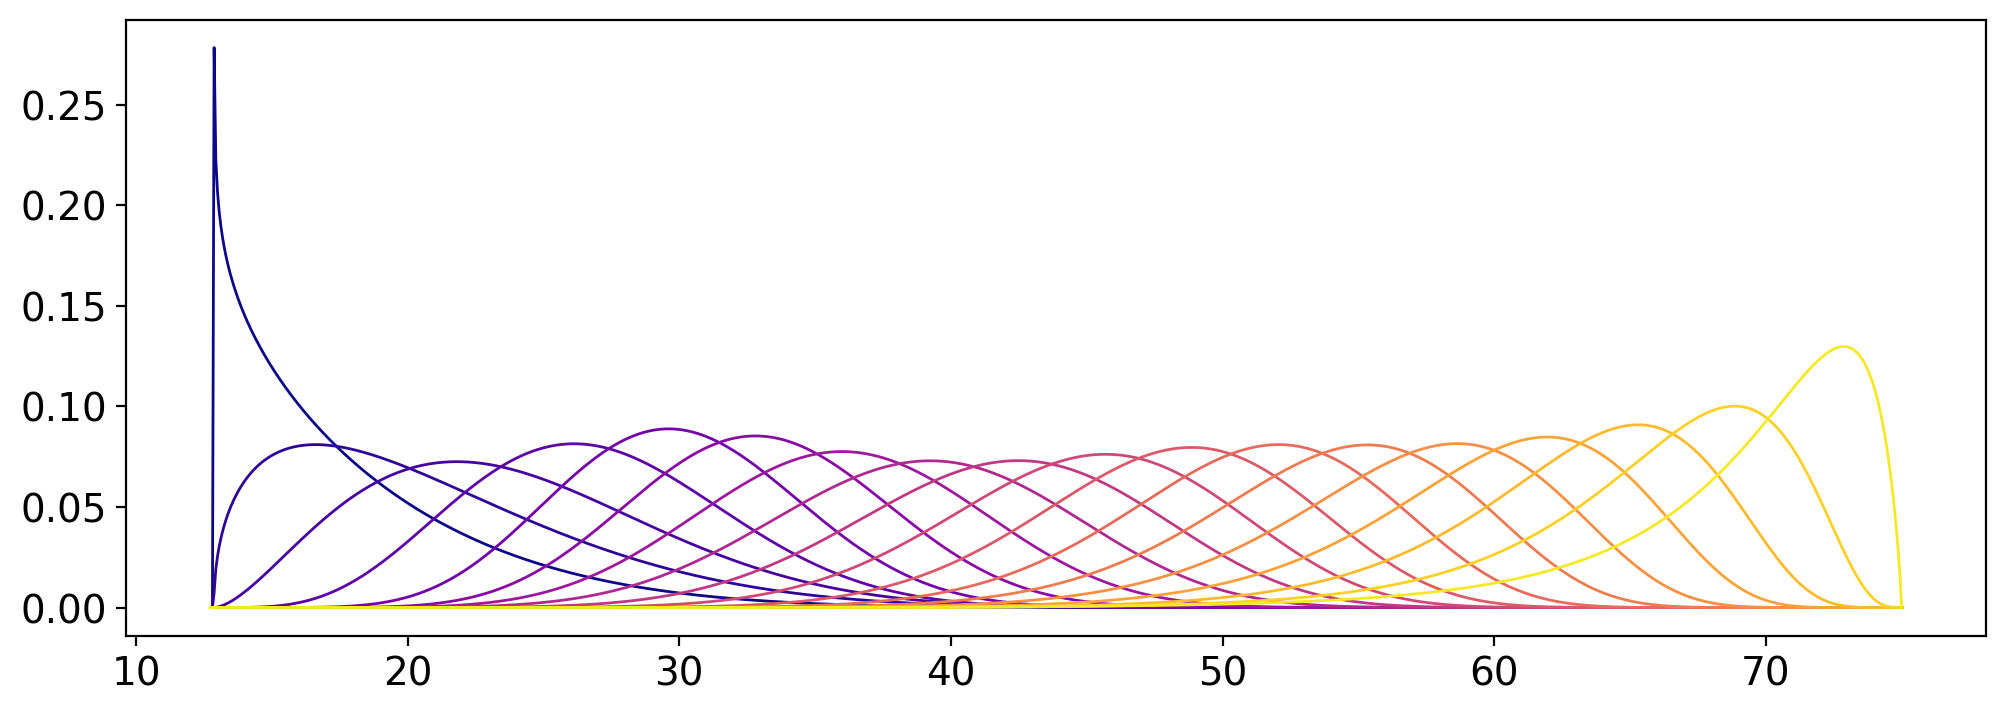

In [10]:
hwhm = np.linspace(12.75, 75, 1000)
for mean in np.arange(18, 71, 3):
    x = (mean - 18) / (71 - 18)
    plt.plot(hwhm, T.pdf(hwhm, mean, 5), color=plt.get_cmap("plasma")(x), lw=1);

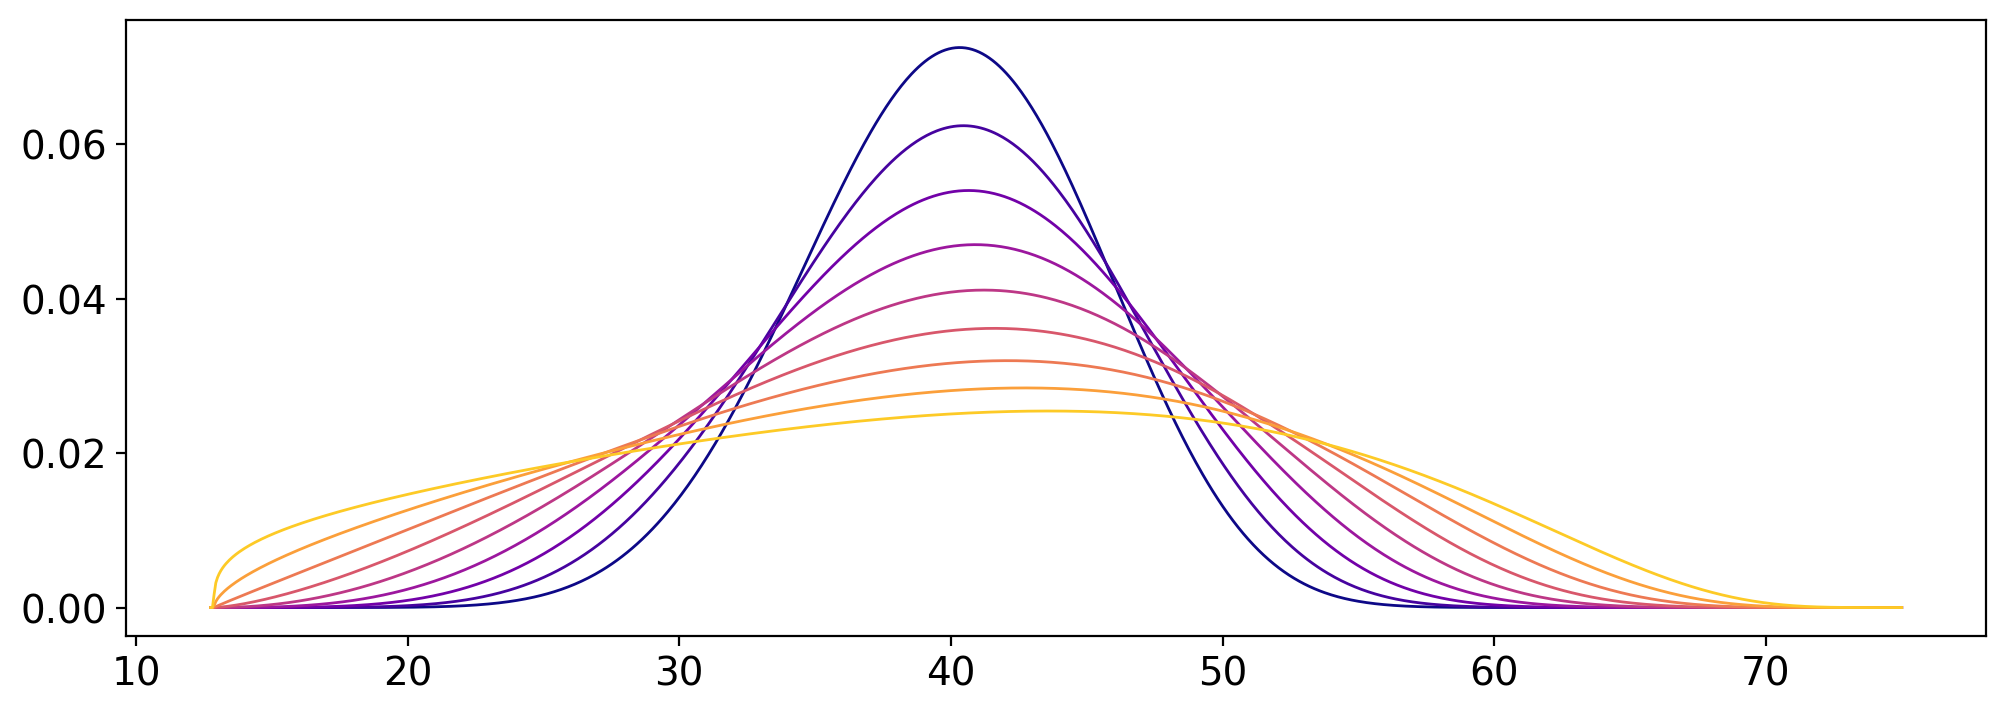

In [11]:
hwhm = np.linspace(12.75, 75, 1000)
for std in np.arange(5, 14):
    x = (std - 5) / (14 - 5)
    plt.plot(hwhm, T.pdf(hwhm, 40, std), color=plt.get_cmap("plasma")(x), lw=1);